# **Adversarial Attack - Data Evasion**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Setup

## 1.1 Install Python Libraries

In [ ]:
!pip install --upgrade pip

!pip install tensorflow -q # for deep learning
!pip install matplotlib -q # for plotting

!pip install adversarial-robustness-toolbox

## 1.2 Import Python Libraries

In [ ]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

# Tensorflow

#import tensorflow as tf
import tensorflow.compat.v1 as tf

# Switch to Graph Mode to run the Attack Model
tf.compat.v1.disable_eager_execution()

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import preprocessing
from tensorflow.keras.applications import resnet


from art.estimators.classification import KerasClassifier
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

## 1.3 Project Configuration

In [ ]:
PROJECT_PATH = Path(".", "drive", "MyDrive", "Project")

ORIGINAL_DS_PATH = Path(
    PROJECT_PATH,
    "dataset",
    "downloads",
    "extracted",
    "TAR_GZ.vis-www.cs.umass.edu_lfw_lfwBV99nGMtc3Dm-0r8dGjUD5cMNKgNTG9Q_-xj9ajVNsA.tgz",
    "lfw",
)

CROPPED_DS_PATH = Path(PROJECT_PATH, "cropped_ds")

CLASSIFICATION_MODEL_FILE = Path(
    PROJECT_PATH, "art-project", "classification_model.keras"
)

IMAGE_SIZE = (200, 200, 3)

# Classifier Training Configuration
TRAINING_SIZE = 288
VALIDATION_SIZE = 96
TEST_SIZE = 96

BATCH_SIZE = 32
FC_NEURONS = 1024
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0001
TRAINING_EPOCHS = 10

NUM_CLASSES = 8

CLASS_NAMES = [
    'Ariel_Sharon',
    'Colin_Powell',
    'Donald_Rumsfeld',
    'George_W_Bush',
    'Gerhard_Schroeder',
    'Hugo_Chavez',
    'Junichiro_Koizumi',
    'Tony_Blair'
    ]

MIN_PIXEL_VALUE = 0
MAX_PIXEL_VALUE = 255

# Attack Configuration
TARGET_IMAGE_FILE = Path(
    PROJECT_PATH, "art-project", "Ariel_Sharon", "Ariel_Sharon_0051.jpg"
)
INIT_IMAGE_FILE = Path(
    PROJECT_PATH, "art-project", "Colin_Powell", "Colin_Powell_0001.jpg"
)

In [ ]:
# Checkers
assert IMAGE_SIZE == (200, 200, 3)

## 1.4 GPU Configuration
❗Please check that GPU enabled

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpu_name = tf.test.gpu_device_name()
print(gpu_name)

/device:GPU:0


# 2. Visualization Functions

In [ ]:
def show_sample(image, label="Sample"):
    if len(image.shape) == 4:
        image = tf.squeeze(image, axis=0)

    height, width, channels = image.shape
    plt.figure(figsize=(4, 4))
    if channels == 1:
        plt.imshow(image.astype(np.uint), cmap="gray")
    else:
        plt.imshow(image.astype(np.uint))
    plt.title(f"{label} shape {image.shape}", fontsize=10)
    plt.axis("off")

    plt.show()

In [ ]:
def show_history(history):
    epochs = range(1, TRAINING_EPOCHS + 1)

    num_of_metrics = max(2, len(history.keys()) // 2)
    fig, ax = plt.subplots(1, num_of_metrics, figsize=(15, 5))
    for i in range(num_of_metrics):
        ax[i].axis("off")

    for i, metric in enumerate(history.keys()):
        if "val_" in metric:
            continue
        ax[i].plot(epochs, history[metric], label=f"Training {metric}")
        ax[i].plot(epochs, history[f"val_{metric}"], label=f"Validation {metric}")
        ax[i].set_title(f"Metric: {metric}")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel("Value")
        ax[i].grid()

        ax[i].legend()
        ax[i].axis("on")
    plt.show()

# 3. Classifier

## 3.1 Dataset Preparation

In [ ]:
def preprocess_image(image):
    """
    NOTE:
    Because of the ResNet preprocess_input() function,
    we can't use the Rescaling and Augmentation Layers.
    """
    return resnet.preprocess_input(image)

In [ ]:
ds = preprocessing.image_dataset_from_directory(
    str(CROPPED_DS_PATH),
    label_mode="int",
    batch_size=None,
    image_size=(200, 200),
    shuffle=True,
)

Found 480 files belonging to 8 classes.


In [ ]:
ds = ds.map(lambda X, y: (preprocess_image(X), y))

# Split our dataset in train, validation and test.
train_ds = ds.take(TRAINING_SIZE)
train_ds = train_ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

val_ds = ds.skip(TRAINING_SIZE).take(VALIDATION_SIZE)
val_ds = val_ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

test_ds = ds.skip(TRAINING_SIZE).skip(VALIDATION_SIZE)
test_ds = test_ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

## 3.2 Load pretrained Classifier
❗Note: it doesn't work in Graph mode , just in Eager mode

In [ ]:
classification_model = tf.keras.models.load_model(str(CLASSIFICATION_MODEL_FILE))
classification_model.compile(
    optimizer=optimizers.legacy.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
eval_info = classification_model.evaluate(test_ds)
for metric_name, metric_val in zip(classification_model.metrics_names, eval_info):
    print(f"{metric_name}: {metric_val}")

print("It doesn't work in Graph mode + tensorflow.compat.v1 version:( !!!! Retrain!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


loss: 4.299043734868367
accuracy: 0.15625
It doesn't work in Graph mode + tensorflow.compat.v1 version:( !!!! Retrain!


## 3.3 Retrain Classifier

In [ ]:
# Build Model
def build_classification_model(
    fc_neurons=FC_NEURONS, dropout_rate=DROPOUT_RATE, lr=LEARNING_RATE, num_classes=NUM_CLASSES
):

    pretrained_model = resnet.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(200, 200, 3),
    )
    # Freeze the pretrained model
    pretrained_model.trainable = False

    # Model Architecture
    input = layers.Input(shape=(200, 200, 3), name="input-image")
    x = pretrained_model(input)
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(fc_neurons, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=input, outputs=output, name="classifier")

    model.compile(
        optimizer=optimizers.legacy.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


classification_model = build_classification_model()
classification_model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-image (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 1024)              102761472 
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 126357384 (482.02 MB)
Trainable params: 10

In [ ]:
# Train the model
train_info = classification_model.fit(
    train_ds, validation_data=val_ds, epochs=TRAINING_EPOCHS
)

# Evaluate the model
eval_info = classification_model.evaluate(test_ds)
for metric_name, metric_val in zip(classification_model.metrics_names, eval_info):
    print(f"{metric_name}: {metric_val}")
eval_info

Train on 9 steps, validate on 3 steps
Epoch 1/10
9/9 [==============================] - 8s 621ms/step - batch: 4.0000 - size: 1.0000 - loss: 5.4920 - accuracy: 0.3021 - val_loss: 1.7928 - val_accuracy: 0.5729
Epoch 2/10
9/9 [==============================] - 2s 119ms/step - batch: 4.0000 - size: 1.0000 - loss: 0.3453 - accuracy: 0.8889 - val_loss: 0.6052 - val_accuracy: 0.7917
Epoch 3/10
9/9 [==============================] - 2s 116ms/step - batch: 4.0000 - size: 1.0000 - loss: 0.0716 - accuracy: 0.9792 - val_loss: 0.5243 - val_accuracy: 0.8646
Epoch 4/10
9/9 [==============================] - 2s 115ms/step - batch: 4.0000 - size: 1.0000 - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.5405 - val_accuracy: 0.8438
Epoch 5/10
9/9 [==============================] - 2s 113ms/step - batch: 4.0000 - size: 1.0000 - loss: 0.0070 - accuracy: 0.9965 - val_loss: 0.5946 - val_accuracy: 0.8438
Epoch 6/10
9/9 [==============================] - 2s 114ms/step - batch: 4.0000 - size: 1.0000 - loss: 0.00

[0.5895240505536398, 0.7916667]

In [ ]:
# Predictions (in inference mode)
def who_is_this(X, model):
    X_expand = np.array([X])

    # Predict the label
    y_preds = model.predict(X_expand, verbose=0)
    y_pred_id = np.argmax(y_preds[0])

    return y_pred_id

# 4. Adversarial Robustness Toolbox (ART) Evasion (HopSkipJump) Attack

In [ ]:
# --- Preprocessing in KerasClassifier defined as a pair (subtrahend, divisor):
# (image - subtrahend) / divisor == to ResNet preprocessing

subtrahend = np.zeros([200, 200, 3])
subtrahend[..., 0].fill(103.939)  # R channel mean (avg)
subtrahend[..., 1].fill(116.779)  # G channel mean
subtrahend[..., 2].fill(123.68)  # B channel mean

# Kind od scale
divisor = np.ones([200, 200, 3])

Target true name is Ariel_Sharon


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


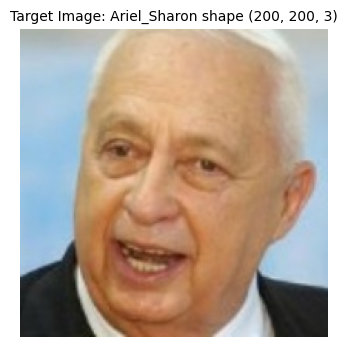

Init true name is Colin_Powell


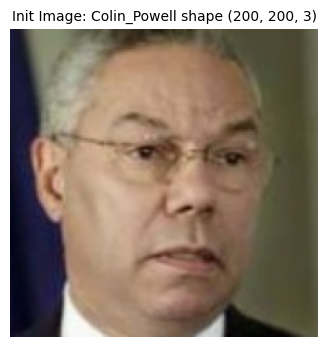

In [ ]:
# --- Create the KerasClassifier wrapper for our model
classifier = KerasClassifier(
    clip_values=(MIN_PIXEL_VALUE, MAX_PIXEL_VALUE),
    model=classification_model,
    preprocessing=(subtrahend, divisor),
)

# --- Get Target and Init Images

# -- TARGET IMAGE
target_image_file = str(TARGET_IMAGE_FILE)
target_y_true = TARGET_IMAGE_FILE.parent.name
print(f"Target true name is {target_y_true}")

# Load image from disk
target_X = preprocessing.image.load_img(target_image_file, target_size=(200, 200))
target_X = preprocessing.image.img_to_array(target_X)

# Predict Label
target_y_pred_id = who_is_this(target_X, classifier)
show_sample(target_X, f"Target Image: {CLASS_NAMES[target_y_pred_id]}")

# -- INIT IMAGE
init_image_file = str(INIT_IMAGE_FILE)
init_y_true = INIT_IMAGE_FILE.parent.name
print(f"Init true name is {init_y_true}")

# Load image from disk
init_X = preprocessing.image.load_img(init_image_file, target_size=(200, 200))
init_X = preprocessing.image.img_to_array(init_X)

# Predict Label
init_y_pred_id = who_is_this(init_X, classifier)
show_sample(init_X, f"Init Image: {CLASS_NAMES[init_y_pred_id]}")

In [ ]:
print(f"{CLASS_NAMES[target_y_pred_id]} will be recognized as {CLASS_NAMES[init_y_pred_id]}!!!!")

Ariel_Sharon will be recognized as Colin_Powell!!!!


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

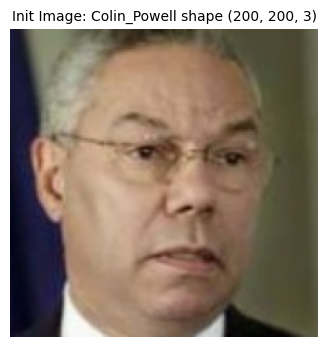

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

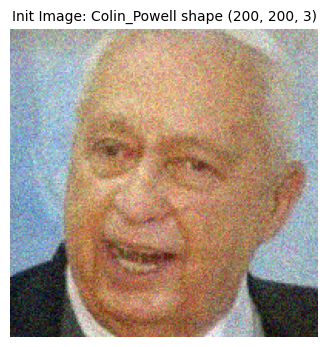

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

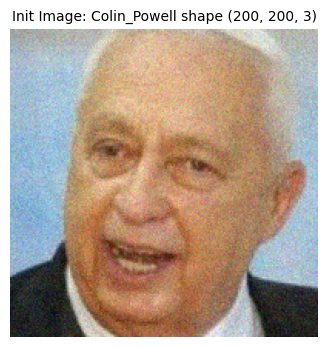

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

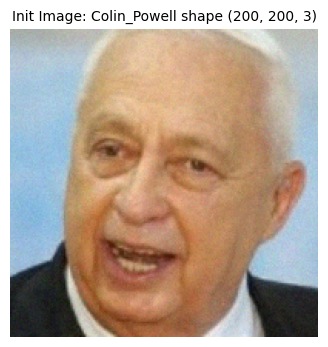

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

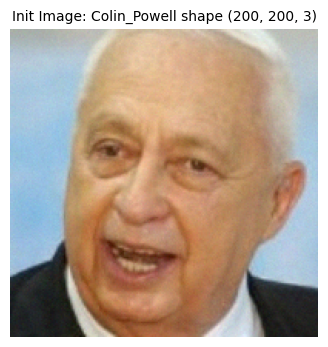

In [ ]:
# Run Attack
max_iterations = 50 # num of runs
max_eval = 1000
init_eval = 10
iter_step = 10

# -- Create HopSkipJump object
attack = HopSkipJump(
    classifier=classifier,
    targeted=True,
    max_iter=0,
    init_eval=init_eval,
    max_eval=max_eval,
)

# Start from init_image
x_adv = np.array([init_X])

# Show every 10 iterations
show_times = int(max_iterations / iter_step)
for i in range(show_times):
    # -- Generate Poisened image
    x_adv = attack.generate(
        x=np.array([target_X]),
        y=to_categorical([init_y_pred_id], NUM_CLASSES),
        x_adv_init=x_adv,
        resume=True,
    )

    init_y_pred_now = who_is_this(x_adv[0], classifier)
    show_sample(x_adv[0].astype(np.uint), f"Init Image: {CLASS_NAMES[init_y_pred_now]}")

    attack.max_iter = iter_step